In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Импортируем все необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

from ipywidgets import interactive

## Импортируем обученную модель

In [ ]:
import pickle

with open('/content/pickle_model.pkl', 'rb') as file:
  clf = pickle.load(file)

In [ ]:
clf

# Прогнозирование поведения клиента (ДЗ)

Привет!

Удачи!

)

#### Задачи:

- Построить кривые CLO rate
- Построить винтажи CLO ratio (1 балл)
- Выбрать переменную для разбивки по бакетам (2 балла)
- Провести анализ поколений (0.5 баллов)
- Построить винтажи CLO rate (2 балла)
- Провести анализ на особые точки (0.5 балла)
- Построить среднее по винтажам для каждого бакета (1 балл)
- Сгладить кривые (2 балла)
    
* Провести анализ на наличие макроэкономического воздействия (4 балла)

В качестве результата приложите текущий ноутбук с названием 'Surname_clo.ipynb'

## Кривые CLO rate

По началу будем делать всё то же самое, что и в def_dlq

#### Начнём. Для начала выгружаем данные с винтажами - кривыми, отражающими зависимость какого-либо парметра от месяца (statement'a). Строятся для каждого поколения - времени отрытия кредита.

In [ ]:
# В качестве данных для винтажей используй файл с семинара data_vintages.csv

In [ ]:
vintage_1 = pd.read_csv(
                        '/content/data_vintages1.csv',
                        sep=",",

                        index_col=0,
                        )

vintage_2 = pd.read_csv(
                        '/content/data_vintages2.csv',
                        sep = ',',

                        index_col=0,
                        )

Объединим две таблицы в одну для удобной работы.

In [ ]:
df = vintage_1.append(vintage_2)
df

### Приводим данные к нормальному виду.

Избавимся от NaN'ов (их немного, так что можем не возиться с аккуратной заменой пропусков). Если оставить NaN'ы, то у меня было много аномалий.

In [ ]:
df.isnull().sum()

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.dtypes

In [ ]:
df.statement_num = df.statement_num.astype(int)
df.gen_month_dt  = pd.to_datetime(df.gen_month_dt)
df.gen_quarter_dt = pd.to_datetime(df.gen_quarter_dt)

In [ ]:
df.dtypes

Избавились, едем дальше.

#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

In [ ]:
df_scores  = pd.read_csv(
                         '/content/data_scores.csv',
                         sep = ';',
                         decimal=',',
                         encoding="cp1251",
                         index_col=0
                         )

df_s_a_f = pd.read_csv(
    '/content/data_scores_and_features.csv',
    decimal=','
    )

In [ ]:
df_s_a_f

Выполним преобразования, подобные прошлому дз, чтобы воспользоваться классификатором.

In [ ]:
df_s_a_f.avg_term = df_s_a_f.avg_term.astype(float)
df_s_a_f.min_term = df_s_a_f.min_term.astype(float)

In [ ]:
df_s_a_f.loc[df_s_a_f.avg_term < 0, 'avg_term'] = 0
df_s_a_f.loc[df_s_a_f.min_term < 0, 'min_term'] = 0

df_s_a_f.dropna(inplace = True, )

In [ ]:
# фичи с прошлого дз для обученной модели

features = ['max_util',
 'last_credit_time_years',
 'soc_dem_score',
 'other_util',
 'credits_4y',
 'min_limit_mfo',
 'close_balance_amt',
 'avg_limit_mortgage',
 'avg_active_time'
 ]

In [ ]:
# и наконец заменяем колонку pd на свою собственную, спрогназированную probability of default

df_s_a_f['pd'] = clf.predict_proba(df_s_a_f[features].astype(float))[:, 1]

In [ ]:
# Тебе понадобятся два скора:
# 1) x_score из файла data_scores.csv
# 2) PD (вероятность дефолта за 12 месяцев), который вы получили в предыдущем ДЗ

#### Бъем выборку на бакеты и джойним с данными с винтажами

In [ ]:
# Разбей данные на 3 бакета по каждой переменной

In [ ]:
df_scores.head()

In [ ]:
df_scores = df_scores.sort_values(['pd'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['pd_bucket'])['pd'].mean())

df_scores = df_scores.sort_values(['x_score'], ignore_index=True)
df_scores['x_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['x_bucket'])['x_score'].mean())

df = df.merge(df_scores[['user_id', 'pd_bucket', 'x_bucket', 'pd', 'x_score']], how='left', on='user_id').dropna()
df.head()

### Построй винтажи кривой Clo ratio (1 балл)


Clo ratio - доля закрытых счетов:
### $$ CLO ratio_n = \frac{\#CLO_n}{\#cnt_n}$$


In [ ]:
# Выгружаем таблицу

close_ratio_data = (df.groupby(["gen_quarter_dt", "statement_num"])       # группировка по поколению и месяцу жизни клиента
        .agg({"clo_flg":np.mean})                                         # считаем средний уровень дефолта
        .rename(columns = {"clo_flg": 'close_ratio'})                     # переименовываем столбец со средними значениями
        .unstack('gen_quarter_dt'))                                       # разворачиваем таблицу, столбцы теперь поколения
close_ratio_data

In [ ]:
def plot_clo_ratio_by_generation(df):

    return (df.groupby(["gen_quarter_dt", "statement_num"])
            .agg({"clo_flg":np.mean})
            .rename(columns = {"clo_flg": 'close_ratio'})
            .unstack('gen_quarter_dt')
            ['close_ratio']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))



# Строим график при помощи pyplot
plot_clo_ratio_by_generation(df)

# Настраиваем параметры отображения графика
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Close ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Выбери переменную, которая делит кривые наилучшим образом (2 балла)

 Из двух скоров (x_score и ваш PD) выбери тот, который разделяет кривые наилучшим образом

Строим по PD

In [ ]:
def plot_clo_ratio_by_bucket(df, bucket):
    return (df.query(''' gen_quarter_dt == '2019-01-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"clo_flg":np.mean})
            .rename(columns = {"clo_flg": 'clo_ratio'})
            .unstack(bucket)
            ['clo_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_clo_ratio_by_bucket(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Close ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

строим по x_score

In [ ]:
plot_clo_ratio_by_bucket(df, 'x_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Close ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод:

Из графиков видно, что лучшее разделение происходит по переменной x_score - расстояние между крывыми больше, они дальше друг от друга, хотя и не столь значительно, как на семинаре. Выбираем его.
Само по себе разделение для нас важно, оно лучше разбивает людей на классы и мы лучше сможем доверять, например, NPV.

### Анализ странных поколений (0.5 баллов)

Отрисуй распределение данных во времени в разбивке по выбранной перменной

In [ ]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_quarter_dt',            # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(df, 'x_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам X", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: сделай выводы по полученным графикам. Нужно ли исключать какие-то бакеты/поколения? Если да, то реализуй их исключение из выборки

Нет, думаю, стоит оставить всё, даже первый квартал, несмотря на то, что его меньше остальных в относительном значении, но в абсолютном всё ещё достаточно много.

### Кривые СLO Rate в разбивке по бакетам

$CLO_n$ - количество счетов, закрывшихся в месяц $n$

$ACT_{n-1}$ - количество активных счетов (в просрочке 0-3) в месяц $n-1$

## $$ CLO Rate_n = \frac{\#CLO_n}{\#Act_{n-1}} $$

Реализуй функцию, которая отрисовывает винтажи CLO rate в разбивке по бакетам

In [ ]:
%matplotlib inline
# Выгружаем таблицу c винтажами

close_rate_data = df.eval('clo_new_flg = clo_flg * prev_act_flg', inplace=False)\
    .groupby(["gen_quarter_dt", 'x_bucket', "statement_num"])\
    .agg({"clo_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"clo_new_flg":'close_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('close_rate = close_cnt / prev_act_cnt', inplace=False)


# Делаем список бакетов

buckets = df['x_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_close_rate_by_generation(x_bucket):

    cur_df = close_rate_data.query('x_bucket == ' + str(x_bucket))
    (cur_df.unstack('gen_quarter_dt')
            ['close_rate']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Close rate, x_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)


# Отображаем его при помощи ipywidget, чтобы получить интерактивность

vintages_graph = interactive(plot_close_rate_by_generation, x_bucket = buckets)
vintages_graph

#### Выводы: Всё как и ожидалось - в первый месяц люди досрочно гасят кредиты, как и в последние (22 месяц особенно выделяется) - наблюдается склонность к росту графика ближе к концу (хотя в последнем, 2ом бакете, такое не наблюдается).



К слову синяя кривая, а это всюду поколение 2019-01-01, вносит много шума как в 0ом, так и в 2ом графиках. Его надо бы исключить из расмотрения

### Особые точки (0.5 баллов)
#### Есть ли в винтажах особые точки? Укажи их. Какова их природа? Нужно ли их исключать?

Опять же, сразу же под подозрение попадает первый месяц. Но такая динамика связана с тем, что клиент может гасить досроно кредит, сразу же в первый месяц. Обычно так делается, когда покупка товара у компании облагается скидкой при условии взятия этого товара в кредит, с которым клиент сразу же расплачивается.

Ещё есть странная точка в 8ом месяце 0ого бакета, но она странная лишь у той самой синей кривой, которую мы исключим.

Очевидная особая точка в 22ом месяце (но только в 0ом и 1ом бакетах для синего и красного поколения), которую стоит исключить. Её причину объяснить так просто не могу - возможно люди решили устроить флеш-моб и погастить все вместе кредит досрочно за 2 месяца (но такая тенденция наблюдается на для каждого бакета, что вызывает вопросы).  


### Среднее по бакетам (1 балл)
Выбери один из способой нахождение средней кривой (возможные способы указаны в лекции). Обоснуй свой выбор.

Реализуй функцию построения среднего. В нашем случае кривые ведут себя примерно одинаково во всех поколениях, поэтому можно оставлять и без взвешенной суммы.

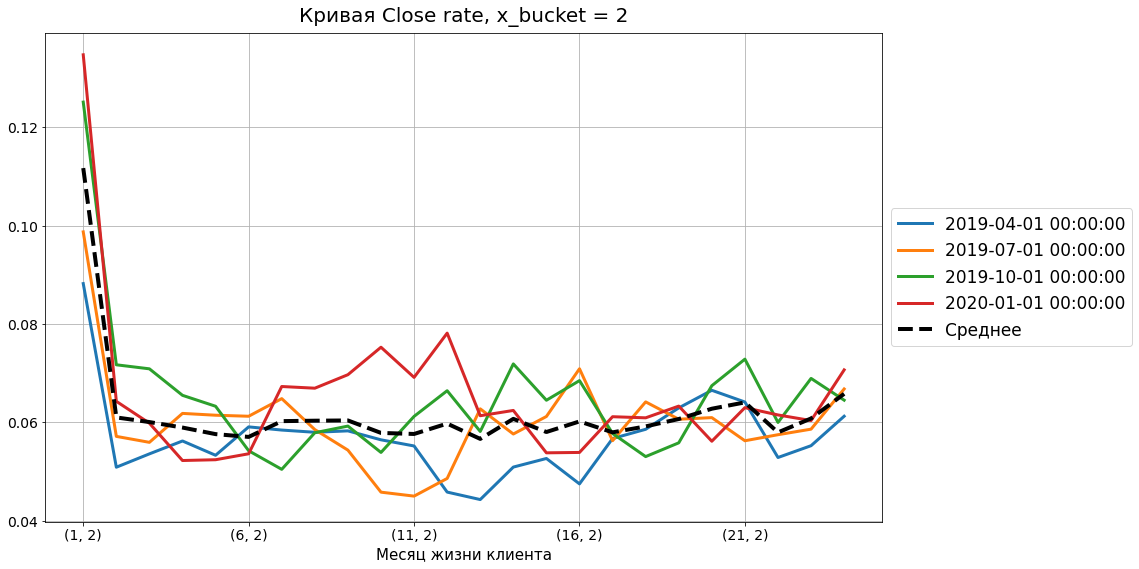

In [ ]:
# Исключаем "странные" поколения

exception_query = ''' ~(   ((gen_quarter_dt == '2019-01-01') & (x_bucket == 2)) or ((gen_quarter_dt == '2019-01-01') & (x_bucket == 0)) or ((gen_quarter_dt == '2019-01-01' or gen_quarter_dt == '2019-10-01') & (x_bucket != 2) & (statement_num == 22))   ) '''
close_rate_data.query(exception_query, inplace = True)

# Реализация расчета среднего

close_rate_mean = close_rate_data.groupby(['statement_num', 'x_bucket', 'gen_quarter_dt']).agg({'close_rate':np.mean})\
    .groupby(['statement_num', 'x_bucket']).agg({'close_rate':np.mean})\
    .rename(columns = {'close_rate':'Среднее'})

buckets = df['x_bucket'].drop_duplicates()

# Построй графики винтажей и среднего

def plot_clo_rate_mean(x_bucket):
    vintages_graph = close_rate_data.query('x_bucket == ' + str(x_bucket))\
            .unstack('gen_quarter_dt')\
            ['close_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (close_rate_mean.query('x_bucket == ' + str(x_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Close rate, x_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

vintages_graph = interactive(plot_clo_rate_mean, x_bucket = buckets)
vintages_graph

### Сглаживание средних кривых (2 балла)

Рассмотри несколько функций для сглаживания кривой (можешь взять готовые из семинара, либо реализовать свои).

In [ ]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

# Делаем аппроксимацию

df_linear = close_rate_mean.query('x_bucket == 1').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 2, 15)

In [ ]:
def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1))
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)
    return df_res


# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 2, 24, 2)

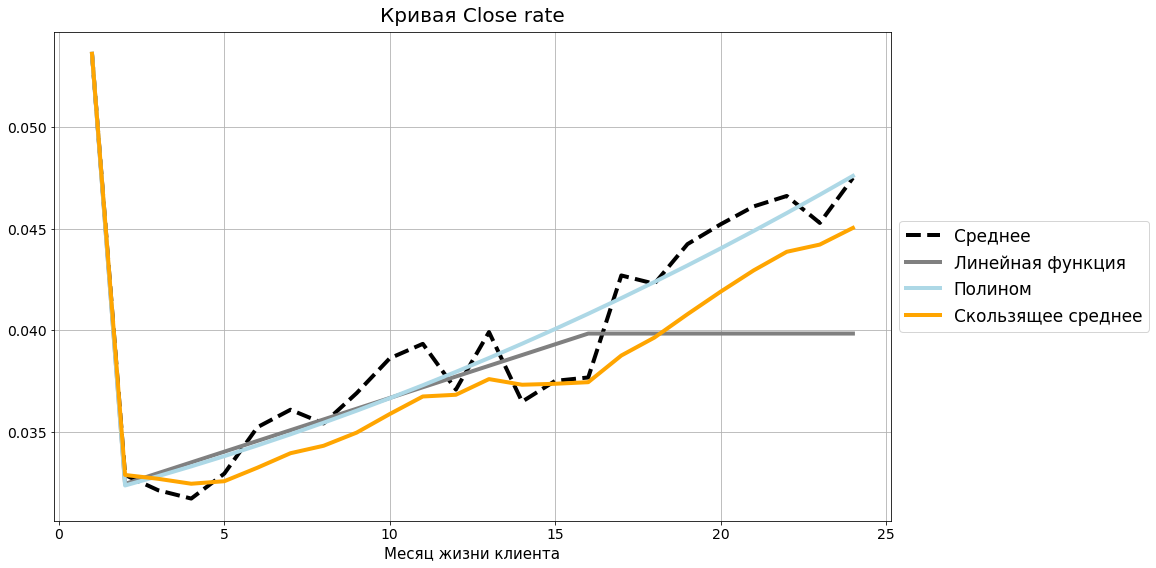

In [ ]:
def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])):
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

# Строим экспоненциальное скользящее среднее с alpha = 0.25
df_smooth = exponential_smoothing(df_polynom, 2, 24, 0.25)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Close rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: укажи выбранную функцию и обоснуй свой выбор. Были ли точки, к которым не применил сглаживание? Почему?

Нам важен тренд.
Линейная функция - ну прям плохо приближает (особенно хвост), не для этой задачи.
Полином - то что надо, не отвлекается на микро-изменения, которые нам по сути и не нужны
А скользящее среднее - слишком чувствительно. Тоже можно, но для тенденции не столь важны колебания, к которым оно неустойчиво.

За стартову точку я взял 2ой месяц, потому что в первый везде наблюдается обоснованное падение rate.

In [ ]:
def approximation(df, start=2, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1))
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)
    return df_res

### Отрисуй сглаженные кривые по всем трем бакетам PD

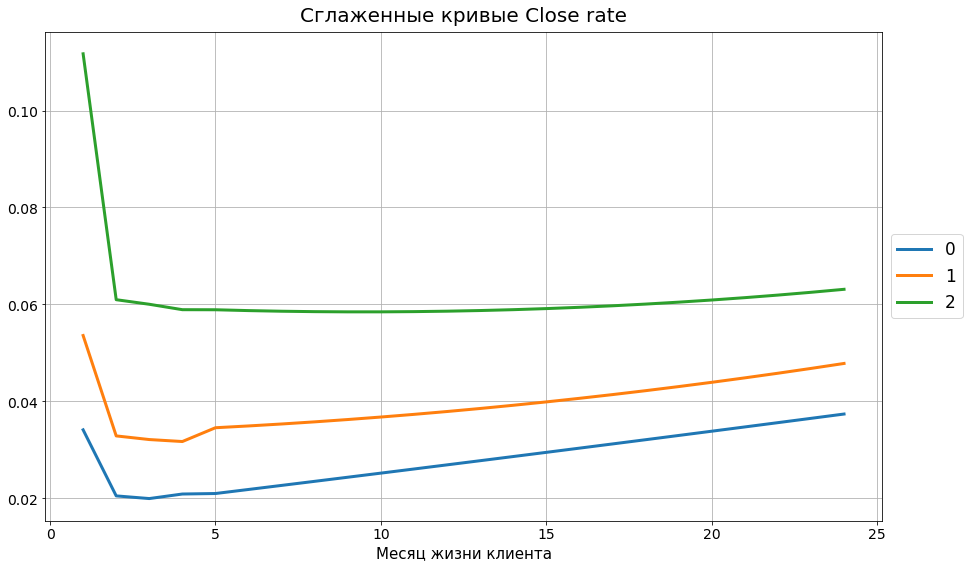

In [ ]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['x_bucket'].drop_duplicates().sort_values()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = close_rate_mean.query('x_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = approximation(df_temp, 5,24,2)['Полином']

# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Close rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

## (Задача со звездочкой)
## Макроэкономические воздействие (4 балла)

#### Есть ли в винтажах CLO rate макроэкономическое воздействие? Если да, то предположи какое событие его вызвало и почему?
#### В случае наличия внешнего влияния
#### 1) Разложи кривые на внешнее воздействие и созревание кривых
#### 2) Отрисуй график внешнего воздествия
#### 3) Отрисуй вычищенные винтажи Clo rate в разбивке по бакетам
#### 4) Посчитай среднее для этих бакетов и реализуй сглаживание

Взглянем ещё раз на тренд clo_rate без вычещенных данных

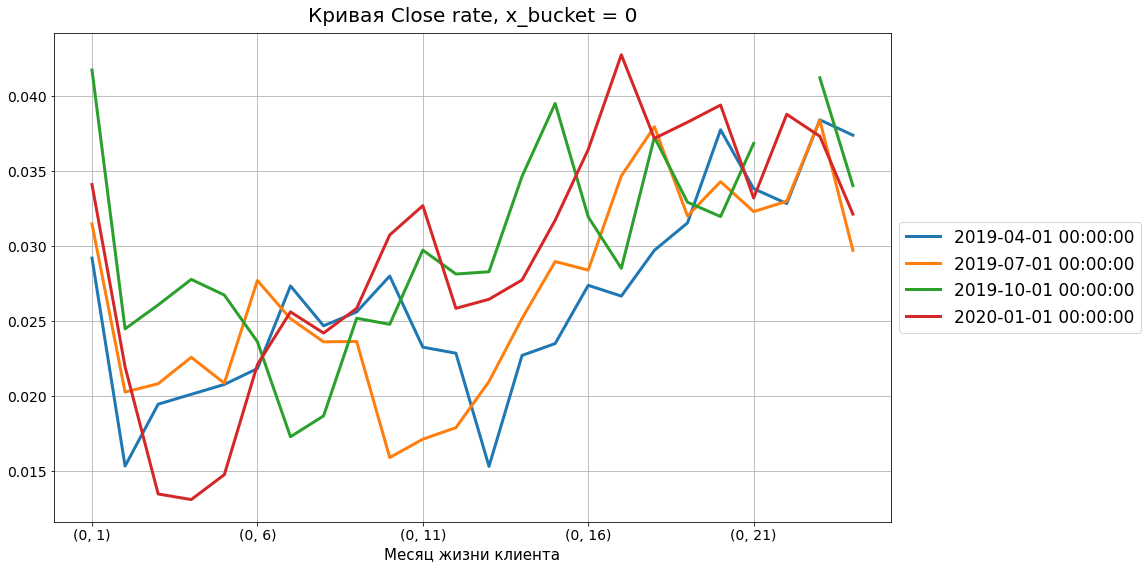

In [ ]:
interactive(plot_close_rate_by_generation, x_bucket = buckets)

Заметен январь 21 года. У многих поколений с разных бакетов наблюдается пик. Сложно его объяснить.

А вот май 20ого года у всех просел - снизилась для закрывания кредита. Думаю, это как раз может быть связано с временами введения локдауна.

Задание не было бы заданием, если бы мы сразу ответили нет и не стали выполнять следующие 4 пункта. Конечно же внешнее воздествие есть и будем раскладывать на составляющие.

## 1) Разложи кривые на внешнее воздействие и созревание кривых

In [ ]:
def curve_build(data,
                feature,
                generation = 'generation_quart',
                statement_num = 'statement_num',
                group_label = '1'):

    """Вспомогательная функция для построения разложения в рамках одного бакета

    **Аргументы**
    data : pandas.DataFrame
        таблица с данными
    feature: str
        название поля с исследуемой переменной
    generation : datetime
        название поля с поколениями
    where : str
        условие, которым мы ограничиваем выборку
    statement_num : int
        название поля с номером месяца жизни клиента
    group_label : str
        название поля группы
    **Результат**
    dictionary : dict
    """

    df_query = data.sort_values([generation, statement_num]).reset_index()

    # Рассчитываем количество поколений и тому подобное
    generation_min = df_query[generation].min()
    gen_cnt = df_query[statement_num].max()

    # Преобразуем Dataframe в набор векторов
    values = np.array(df_query[feature])
    tab_size = df_query[feature].count()
    st_nums = np.array(df_query[statement_num] - 1)
    dates = np.array([0 for i in range(tab_size)])

    for i in range(tab_size):
         dates[i] = df_query.loc[i,generation].year * 12 + df_query.loc[i,generation].month -\
            generation_min.year * 12 - generation_min.month + df_query.loc[i,statement_num] - 1

    # Определяем функционал, который будем минимизировать

    def r_square(x):
        temp = 0
        for i in range(tab_size):
            if dates[i] >= 0:
                temp += (values[i] - x[dates[i]] * x[st_nums[i] + gen_cnt])**2
        return temp

    # Задаем callback для отслеживания прогресса минимизации
    def callbackF(Xi):
        global Nfeval
        print('%d  %.6f' % (Nfeval, r_square(Xi)))
        Nfeval += 1

    # Задаем начальное приближение в виде массива с нулевыми значениями

    x0 = np.array([0 for i in range(2*gen_cnt)])                                # Внешние воздействия

    # Численная минимизация

    print('Initial %.6f' % (r_square(x0)))
    res0 = minimize(r_square, x0, tol=1e-6, callback=callbackF, method='Powell', options = {'disp': False, 'maxiter': 1000})

    # Задаем датафрейм с внешними воздействиями
    external_data = pd.DataFrame({'month_dt': [generation_min + pd.DateOffset(months = i) for i in range(gen_cnt)],
                             group_label: res0.x[:gen_cnt]})

    # Нормируем внешние воздействия таким образом, чтобы в среднем они равнялись единице.
    ext_mean = external_data[external_data['month_dt'] > generation_min + pd.DateOffset(months = 6)][group_label].mean()
    external_data[group_label] = external_data[group_label] / ext_mean

    # И умножаем на полученный коэффициент кривые созревания

    maturation_array = np.transpose([res0.x[gen_cnt:2* gen_cnt] * ext_mean]).flatten()
    maturation_data = pd.DataFrame(data = {group_label: maturation_array, \
                                           'statement_num': np.arange(1,maturation_array.size + 1)})

    df_fitted = df_query.merge(right=external_data, on = 'month_dt')
    df_fitted['fitted_feature'] = df_fitted[feature] / df_fitted[group_label]

    # Формируем словарь c итоговыми данными
    res = {'res0': res0,
          'external_data': external_data,
          'maturation_data': maturation_data,
          'df_fitted': df_fitted}
    return res


def decomposition(df,
                  generation = 'generation_month',
                  group = 'bucket',
                  statement_num = 'statement_num',
                  feature = 'feature',
                  optimization_query = ''):
    """Винтажи исследуемой переменной по календарному времени

    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов

    if optimization_query == '':
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)

    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x-1))
    df_query['month_dt'] = df_query[generation] + timedelta

      # Формируем список бакетов

    df_query.sort_values(by = [group], inplace = True)
    groups = pd.Series(df_query[group].drop_duplicates())

    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + ' = ' + str(g))

        # Строим разложение для одного бакета
        res = curve_build(df_temp,
                          feature = feature,
                          generation = generation,
                          statement_num = statement_num,
                          group_label = str(g)
                         )
        df_fitted_temp = pd.DataFrame(res['df_fitted'])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res['external_data'])[['month_dt', str(g)]]
            maturation_data = pd.DataFrame(res['maturation_data'])[[statement_num, str(g)]]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(right = res['external_data'], on = ['month_dt'])
            maturation_data = maturation_data.merge(right = res['maturation_data'], on = [statement_num])
            df_fitted = pd.concat([df_fitted, df_fitted_temp])
        i+=1

    res_multiple = {
                    'external_data': external_data,
                    'maturation_data': maturation_data,
                    'fitted_data': df_fitted
                   }
    return res_multiple

In [ ]:
close_rate_data = df.eval('clo_new_flg = clo_flg * prev_act_flg', inplace=False)\
    .groupby(["gen_month_dt", 'x_bucket', "statement_num"], as_index=False)\
    .agg({"clo_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"clo_new_flg":'close_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('close_rate = close_cnt / prev_act_cnt', inplace=False)

# Счетчик итераций
Nfeval = 0

# Проводим разложение кривых
res = decomposition(close_rate_data,
                       generation = 'gen_month_dt',
                       group = 'x_bucket',
                       statement_num = 'statement_num',
                       feature = 'close_rate')

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1190: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


x_bucket = 0
Initial 0.289951
0  0.126349
1  0.119955
2  0.119766
3  0.119697
4  0.119661
5  0.119641
6  0.119599
7  0.119589
8  0.119260
9  0.119154
10  0.118596
11  0.118373
12  0.117427
13  0.116961
14  0.114699
15  0.113131
16  0.103331
17  0.091798
18  0.058679
19  0.045543
20  0.037294
21  0.033291
22  0.031119
23  0.028250
24  0.028023
25  0.027834
26  0.027159
27  0.027140
28  0.027129
29  0.027123
30  0.027120
31  0.027117
32  0.027116
33  0.027112
34  0.027112
35  0.027112
36  0.027111
37  0.027110
38  0.027110
39  0.027106
40  0.027104
41  0.027077
42  0.027068
43  0.026866
44  0.026783
45  0.023451
46  0.022540
47  0.013660
48  0.012852
49  0.012420
50  0.012145
51  0.011507
52  0.011449
53  0.011416
54  0.011395
55  0.011382
56  0.011350
57  0.011348
58  0.011346
59  0.011345
60  0.011344
61  0.011342
62  0.011341
63  0.011341
64  0.011341
65  0.011341
66  0.011341
x_bucket = 1
Initial 0.577256
67  0.214576
68  0.204196
69  0.203694
70  0.203473
71  0.203362
72  0.203300
7

## 2) Отрисуй график внешнего воздествия

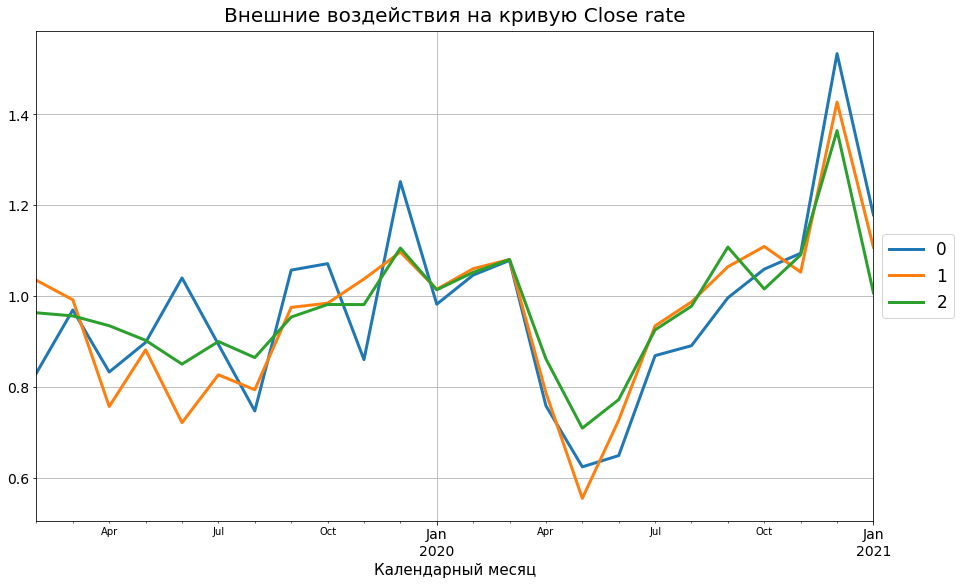

In [ ]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешние воздействия на кривую Close rate", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Как раз видим сильное проседание в мае 20 года

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


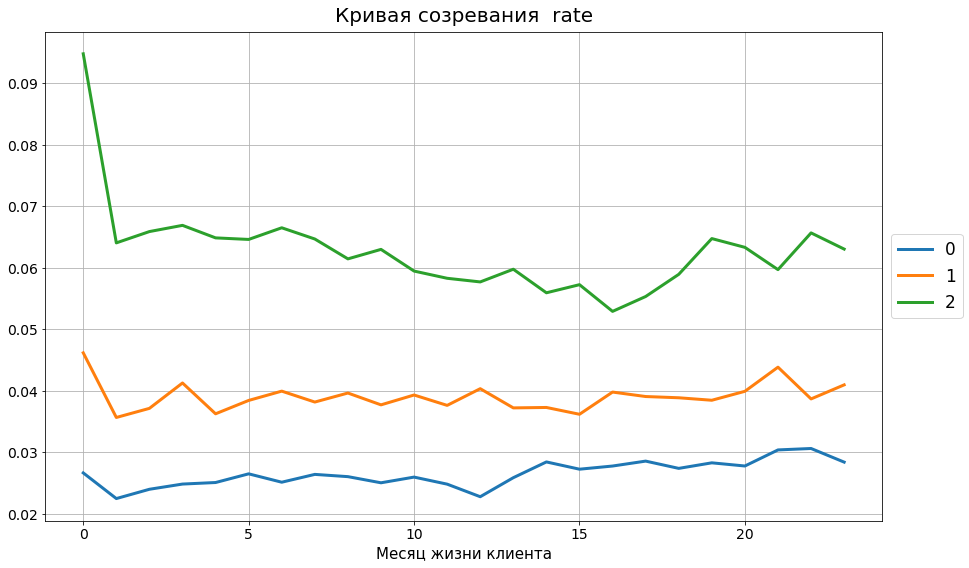

In [ ]:
res['maturation_data'].drop('statement_num', 1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая созревания  rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

## 3) Отрисуй вычищенные винтажи Clo rate в разбивке по бакетам

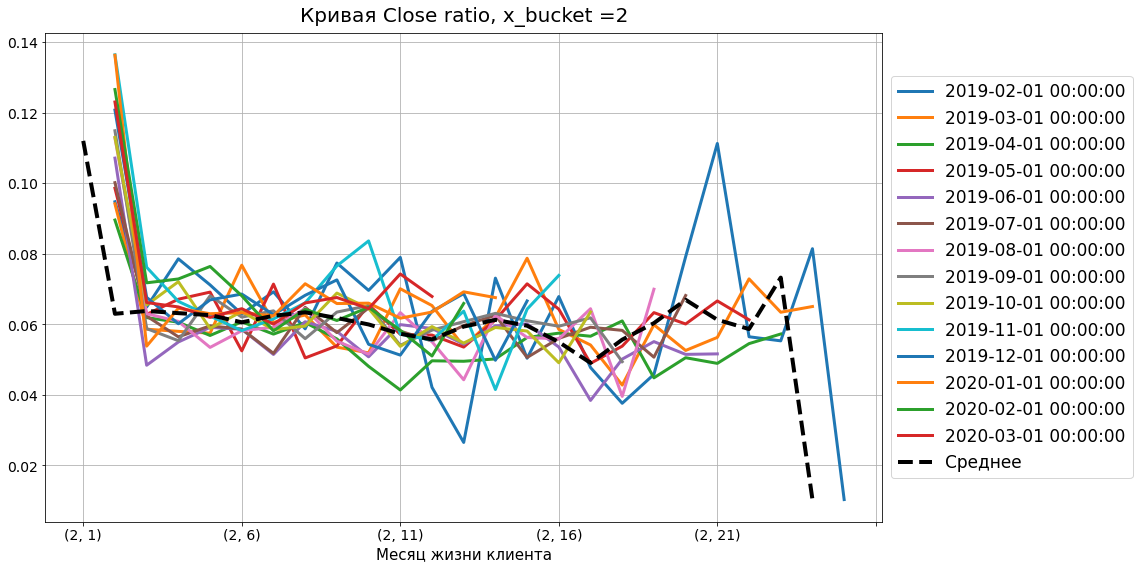

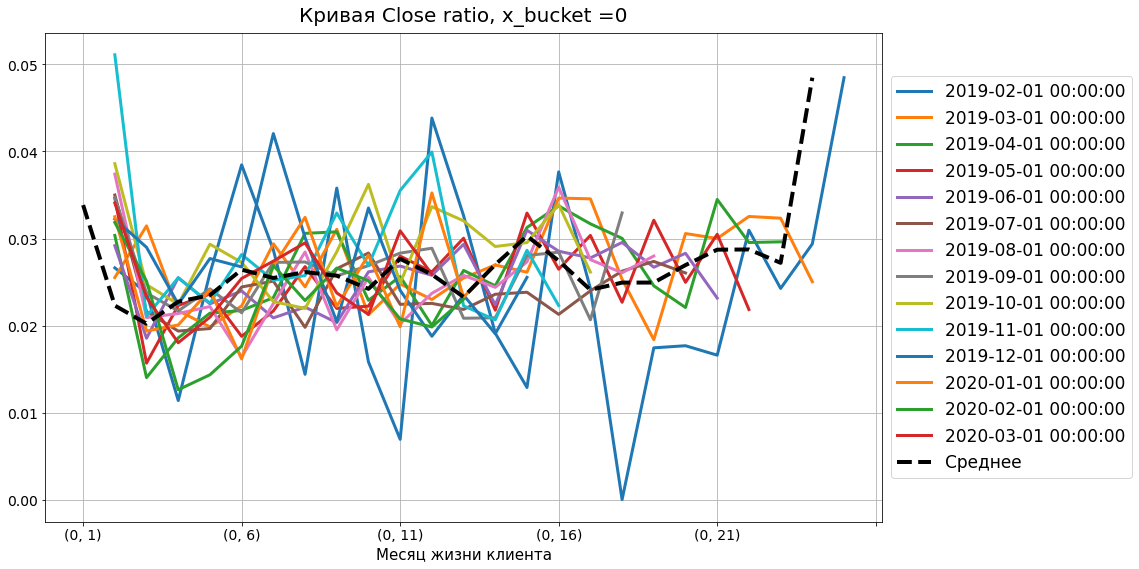

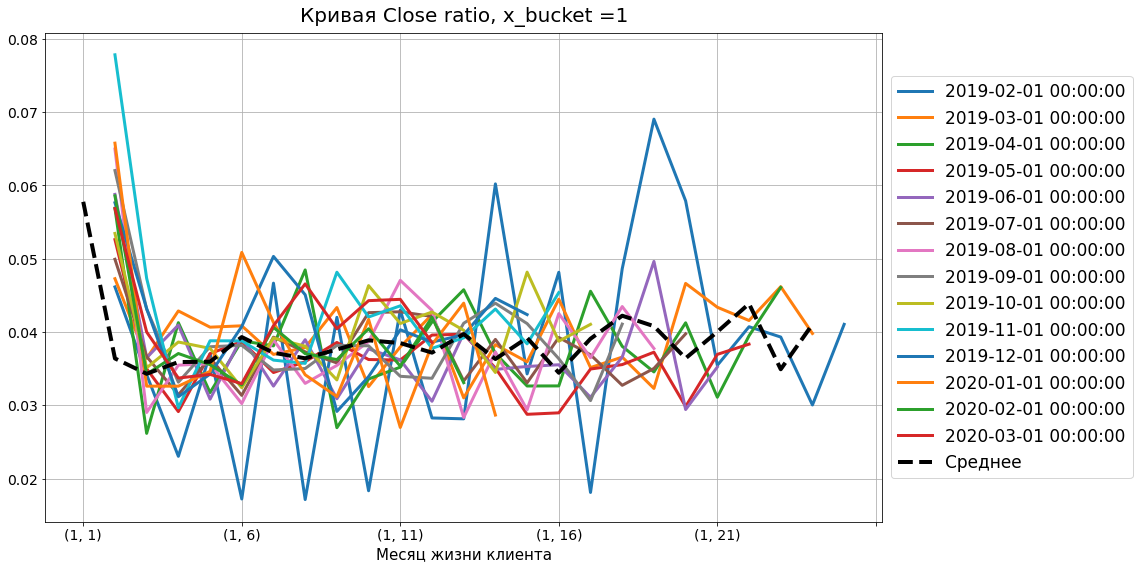

In [ ]:
# Считаем среднее

clo_rate_mean = res['fitted_data'].groupby([ 'x_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.mean})\
    .rename(columns = {'fitted_feature':'Среднее'})

buckets = df['x_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_clo_rate_mean(x_bucket):
    vintages_graph = res['fitted_data'].query('x_bucket == ' + str(x_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature":np.sum})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                              # график винтажей
    (clo_rate_mean.query('x_bucket == ' + str(x_bucket))['Среднее']
             .plot( figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))                    # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                  # чтобы отобразить их вместе
    plt.title("Кривая Close ratio, x_bucket =" + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in buckets:
    plot_clo_rate_mean(i)

## 4) Посчитай среднее для этих бакетов и реализуй сглаживание

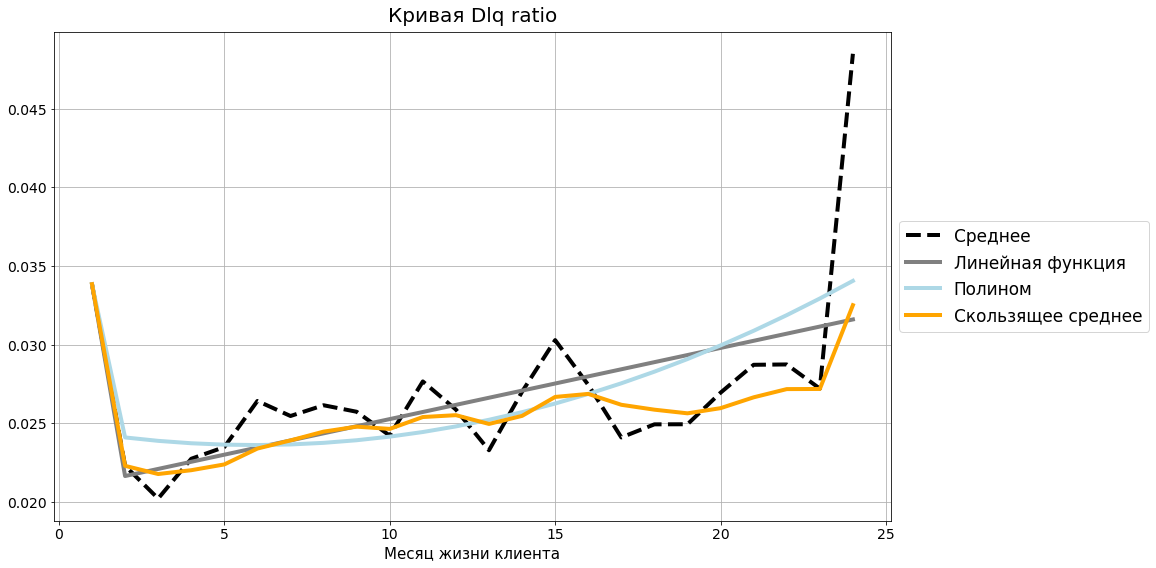

In [ ]:
df_linear = clo_rate_mean.query('x_bucket == 0').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 2, 24)
df_polynom = polynom_approximation(df_linear, 2,24,2)
df_smooth = exponential_smoothing(df_polynom, 2,24, 0.25)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Оставляем полином. Он в целом мне нравится, да и тренд показывает.

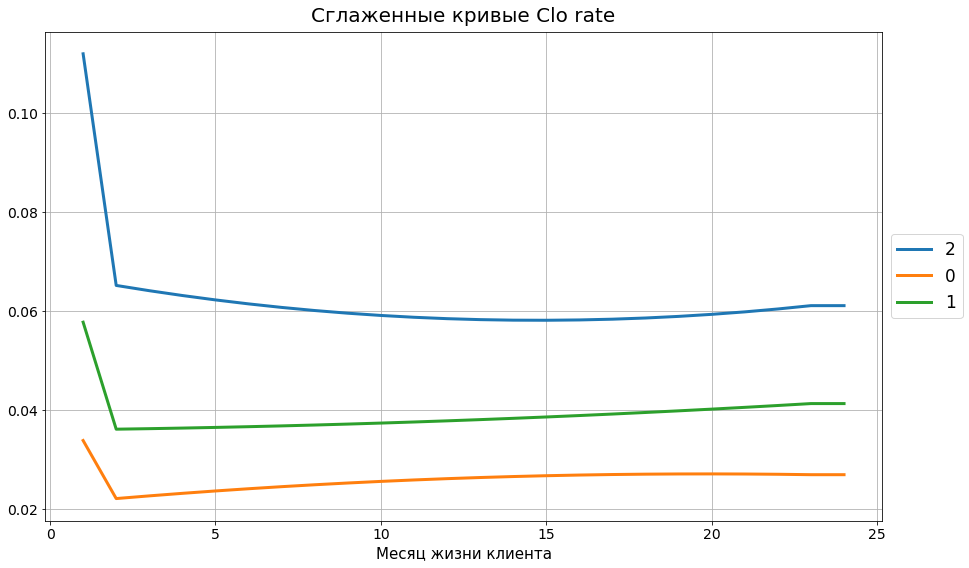

In [ ]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['x_bucket'].drop_duplicates()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = clo_rate_mean.query('x_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 2,22,2)['Полином']

# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)